## Identifiability Test of Linear VAE on KittiMask Dataset

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import ltcl
import numpy as np
import scipy
from ltcl.datasets.kitti import KittiMasks
from ltcl.modules.linear_vae import AfflineVAECNN
from ltcl.modules.metrics.correlation import correlation
import random
import seaborn as sns
from torchvision import transforms
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

### Load KittiMask dataset

In [4]:
use_cuda = True
device = torch.device("cuda:2" if use_cuda else "cpu")
latent_size = 10
nc = 1

In [5]:
data = KittiMasks(path = '/home/cmu_wyao/projects/data/kitti/', 
                  transform = None,
                  max_delta_t = 5)
num_validation_samples = 2500
train_data, val_data = random_split(data, [len(data)-num_validation_samples, num_validation_samples])
train_loader = DataLoader(train_data, batch_size=1280, shuffle=True, pin_memory=True)
val_loader   = DataLoader(val_data, batch_size=16, shuffle=False, pin_memory=True)

### Load model

In [6]:
model = AfflineVAECNN(nc,latent_size,1).to(device)

/home/cmu_wyao/projects/ltcl/ltcl/modules/components/beta.py:168: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  init.kaiming_normal(m.weight)


In [69]:
diag_ckp = "/data/datasets/logs/cmu_wyao/linear_vae_kitti_1lag_10_gamma_10_diag/lightning_logs/version_21/checkpoints/epoch=249-step=302999.ckpt"
lin_ckp = "/data/datasets/logs/cmu_wyao/kitti_10_g25_linear/lightning_logs/version_9/checkpoints/epoch=99-step=126899.ckpt" 

In [70]:
model = model.load_from_checkpoint(diag_ckp,
                                   z_dim = 10, nc=1, lag=1, diagonal=True, hidden_dim=512)

/home/cmu_wyao/projects/ltcl/ltcl/modules/components/beta.py:168: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  init.kaiming_normal(m.weight)


In [71]:
model.to(device)

AfflineVAECNN(
  (net): BetaVAE_CNN(
    (encoder): Sequential(
      (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU(inplace=True)
      (9): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (11): ReLU(inplace=True)
      (12): Conv2d(64, 512, kernel_size=(4, 4), stride=(1, 1))
      (13): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running

### Visualization of MCC and causal matrix

In [72]:
for batch in train_loader:
    for key in batch:
        batch[key] = batch[key].to(device)
    break
batch_size = batch['xt'].shape[0]

/home/cmu_wyao/anaconda3/envs/py37/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Learned noise prior')

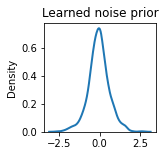

In [73]:
fig = plt.figure(figsize=(2,2))
eps = model.sample(batch["xt"])
eps = eps.detach().cpu().numpy()
component_idx = 7
sns.distplot(eps[:,component_idx], hist=False, kde=True,
             bins=None,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2});
plt.title("Learned noise prior")

In [74]:
x_recon, mu, logvar, z = model.forward(batch)
mu = mu.view(batch_size, -1, latent_size)
A = mu[:,0,:].detach().cpu().numpy()
B = batch['yt'][:,0,:].detach().cpu().numpy()

In [75]:
A = A.T
B = B.T

In [76]:
result = np.zeros(A.shape)
result[:B.shape[0],:B.shape[1]] = B
for i in range(len(A) - len(B)):
    result[B.shape[0] + i, :] = np.random.normal(size=B.shape[1])
corr_sorted, sort_idx, mu_sorted = correlation(A, result, method='Spearman')

Calculating correlation...


Text(0.5, 1.0, 'MCC=0.891')

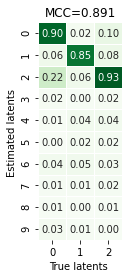

In [77]:
fig = plt.figure(figsize=(1.5,4))
sns.heatmap(np.abs(corr_sorted[:,:3]), vmin=0, vmax=1, annot=True, fmt=".2f", linewidths=.5, cbar=False, cmap='Greens')
plt.xlabel("True latents ") 
plt.ylabel("Estimated latents ") 
plt.title("MCC=%.3f"%np.abs(np.diag(corr_sorted)[:3]).mean())

In [26]:
col_ind = sort_idx[:3].astype('int')
print('Permutation:', col_ind)

Permutation: [3 8 7]


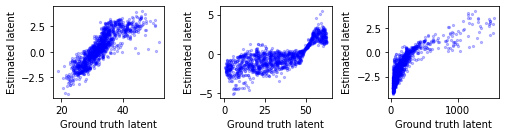

In [66]:
fig, axs = plt.subplots(1,3, figsize=(7,2))
for i in range(3):
    ax = axs[i]
    ax.scatter(B.T[:,i], A.T[:,col_ind[i]], s=5, color='b', alpha=0.25)
    ax.set_xlabel('Ground truth latent')
    ax.set_ylabel('Estimated latent')
fig.tight_layout()

Text(0.5, 1.0, 'Causal transition matrix')

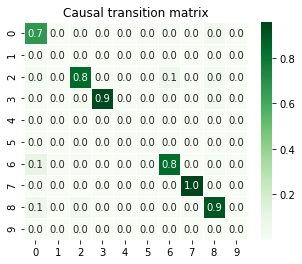

In [68]:
fig = plt.figure(figsize=(5,4))
sns.heatmap(np.abs(model.trans_func.w[0].detach().cpu().numpy()),
             annot=True, fmt=".1f", linewidths=.5, cbar=True, cmap='Greens')
plt.title('Causal transition matrix')

### Latent traversal

In [192]:
x_recon, mu, logvar, z = model.forward(batch)

In [193]:
x_recon_traverse = model.net._decode(mu)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


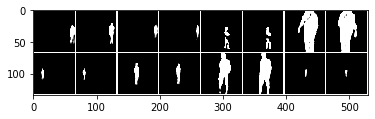

In [199]:
show(make_grid(x_recon.detach().cpu(), nrow=8, pad_value=1))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


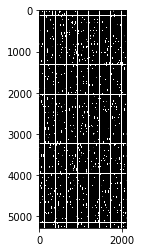

In [143]:
show(make_grid(x_recon_traverse.detach().cpu(), nrow=32, pad_value=1))